In [1]:
%matplotlib inline
import importlib
import utils2; importlib.reload(utils2)
from utils2 import *

from tqdm import tqdm

Using TensorFlow backend.
/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
limit_mem()

In [3]:
from keras.datasets import mnist
(X_train,Y_train), (X_test, Y_test) = mnist.load_data()

In [4]:
X_train.shape

(60000, 28, 28)

In [5]:
n = len(X_train);n

60000

In [6]:
X_train = X_train.reshape(n,-1).astype(np.float32)
X_test = X_test.reshape(len(X_test),-1).astype(np.float32)

In [7]:
X_train/= 255.; X_test /= 255.

In [8]:
X_train.shape

(60000, 784)

In [9]:
def noise(bs): return np.random.rand(bs,100)

In [10]:
#def data_D(sz,G):
    real_img = X_train[np.random.randint(0,n,size=sz)]
    X = np.concatenate((real_img, G.predict(noise(sz))))
    return X,[0]*sz +[1]*sz
    

IndentationError: unexpected indent (<ipython-input-10-aa6f9395c448>, line 2)

In [11]:
def data_D(sz, G):
    real_img = X_train[np.random.randint(0,n,size=sz)]
    X = np.concatenate((real_img, G.predict(noise(sz))))
    return X, [0]*sz + [1]*sz

### MLP GAN

In [137]:
MLP_D = Sequential([
    Dense(300,input_shape=(784,),activation='relu'),
    Dense(300,activation='relu'),
    Dense(1,activation='sigmoid')
])
MLP_D.compile(Adam(1e-4),'binary_crossentropy')

In [138]:
MLP_G = Sequential([
    Dense(200,input_shape=(100,), activation='relu'),
    Dense(400,activation='relu'),
    Dense(784,activation='sigmoid')
])

In [139]:
MLP_m = Sequential([MLP_G,MLP_D])
MLP_m.compile(Adam(1e-4), "binary_crossentropy")

In [140]:
MLP_m = Sequential([MLP_G,MLP_D])
MLP_m.compile(Adam(1e-4),'binary_crossentropy')

In [22]:
def make_trainable(net,val):
    net.trainable= val
    for l in net.layers: l.trainable = val

In [24]:
def train(D, G, m, nb_epoch=5000, bs=128):
    dl,gl=[],[]
    for e in tqdm(range(nb_epoch)):
        X,y = data_D(bs//2, G)
        dl.append(D.train_on_batch(X,y))
        make_trainable(D, False)
        gl.append(m.train_on_batch(noise(bs), np.zeros([bs])))
        make_trainable(D, True)
    return dl,gl

In [143]:
dl,gl = train(MLP_D,MLP_G,MLP_m,8000)

  4%|▍         | 323/8000 [00:06<02:38, 48.41it/s]


KeyboardInterrupt: 

In [28]:
def plot_gen(G,n_ex=16):
    plot_multi(G.predict(noise(n_ex)).reshape(n_ex,28,28),cmap='gray')

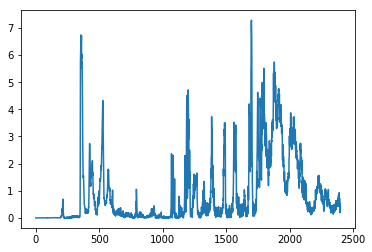

In [29]:
plt.plot(dl[100:])

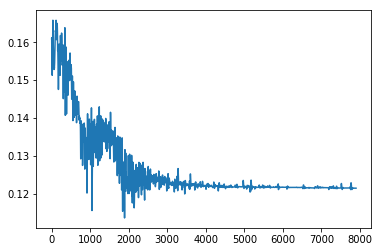

In [73]:
plt.plot(gl[100:])

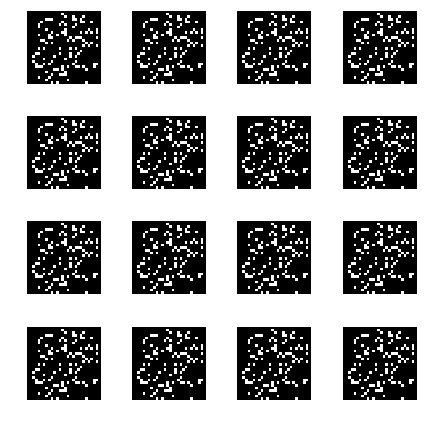

In [76]:
plot_gen(MLP_G)

## DCGAN

In [12]:
X_train = X_train.reshape(n,28,28,1)
X_test = X_test.reshape(len(X_test),28,28,1)

In [13]:
X_train.shape

(60000, 28, 28, 1)

In [14]:
CNN_G = Sequential([
    Dense(512*7*7,input_dim=100,activation=LeakyReLU()),
    BatchNormalization(),   
    Reshape((7,7,512)),
    UpSampling2D(),
    Convolution2D(64,3,3,border_mode='same',activation=LeakyReLU()),
    BatchNormalization(),
    UpSampling2D(),
    Convolution2D(32,3,3,border_mode='same',activation=LeakyReLU()),
    BatchNormalization(),
    Convolution2D(1,1,1,border_mode='same',activation='sigmoid')
    
    
])

/home/ubuntu/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), activation=<keras.lay..., padding="same")`
  
/home/ubuntu/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (3, 3), activation=<keras.lay..., padding="same")`
  if __name__ == '__main__':
/home/ubuntu/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(1, (1, 1), activation="sigmoid", padding="same")`
  # This is added back by InteractiveShellApp.init_path()


In [17]:
CNN_D = Sequential([
    Convolution2D(256,5,5,subsample=(2,2),activation=LeakyReLU(),border_mode='same',input_shape=(28,28,1)),
    Convolution2D(512,5,5,subsample=(2,2),activation=LeakyReLU(),border_mode='same'),
    Flatten(),
    Dense(256,activation=LeakyReLU()),
    Dense(1,activation='sigmoid')   
    
    
])

/home/ubuntu/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(256, (5, 5), activation=<keras.lay..., input_shape=(28, 28, 1..., strides=(2, 2), padding="same")`
  
/home/ubuntu/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(512, (5, 5), activation=<keras.lay..., strides=(2, 2), padding="same")`
  This is separate from the ipykernel package so we can avoid doing imports until


In [18]:
CNN_D.compile(Adam(1e-4),'binary_crossentropy')

In [19]:
sz = n//200
x1 = np.concatenate([np.random.permutation(X_train)[:sz], CNN_G.predict(noise(sz))])
CNN_D.fit(x1, [0]*sz + [1]*sz, batch_size=32, nb_epoch=1, verbose=2)

/home/ubuntu/anaconda3/lib/python3.6/site-packages/keras/models.py:826: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  warnings.warn('The `nb_epoch` argument in `fit` '


Epoch 1/1
1s - loss: 0.2228


In [20]:
CNN_m = Sequential([CNN_G,CNN_D])
CNN_m.compile(Adam(1e-4),'binary_crossentropy')

In [39]:
K.set_value(CNN_D.optimizer.lr, 1e-5)
K.set_value(CNN_m.optimizer.lr, 1e-5)

In [40]:
dl,gl = train(CNN_D,CNN_G,CNN_m,2500)

100%|██████████| 2500/2500 [13:15<00:00,  3.14it/s]


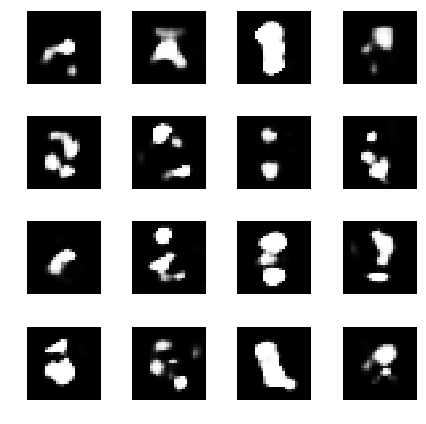

In [41]:
plot_gen(CNN_G)

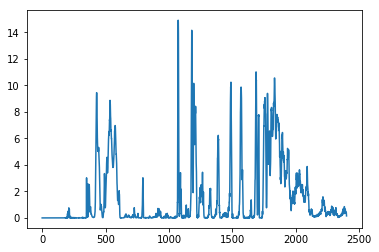

In [32]:
plt.plot(gl[100:])

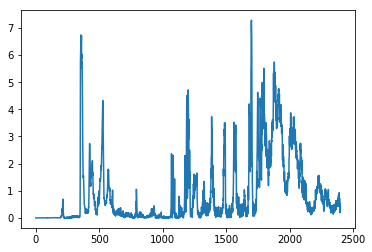

In [33]:
plt.plot(dl[100:])